# Implement a neural network for m-samples, n-features as we discussed in class (both FP and BP) and for N layers in the hidden layer. Split the data (you can use the log. reg. data or any other one) and train your network with 70% of the data. Use 15% for validation  and test your network with the remaining 15% data. Report the evaluation metrics for varying number of layers in the network. Plot the training loss curves.



In [17]:
import pandas as pd
df = pd.read_csv("Logistic_regression_ls.csv")
df

,x1,x2,label
0,7.395,7.638,1
1,4.987,6.485,1
2,5.358,6.499,1
3,2.036,2.380,0
4,5.956,7.378,1
...,...,...,...
495,0.304,1.608,0
496,6.140,4.261,1
497,6.579,6.231,1
498,2.555,0.446,0


In [18]:
X = df[['x1','x2']].values
print(X.shape)
y = df[['label']].values
print(y.shape)



(500, 2)
(500, 1)


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Splliting the traing and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Train data shape:")
print(X_train.shape)
print(y_train.shape)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Validation data shape:")
print(X_valid.shape)
print(y_valid.shape)
print("Test data shape:")
print(X_test.shape)
print(y_test.shape)

Train data shape:
(350, 2)
(350, 1)
Validation data shape:
(75, 2)
(75, 1)
Test data shape:
(75, 2)
(75, 1)


# Normalise the train test and validation data

In [20]:
X_train = (X_train - X_train.min())/(X_train.max() - X_train.min())
X_test = (X_test - X_test.min())/(X_test.max() - X_test.min())
X_valid = (X_valid - X_valid.min())/(X_valid.max() - X_valid.min())


# Flexible Neural Network

In [21]:
import numpy as np
def init_N_network( num_hidden_layer, num_nodes_hidden_layers, input_size, output_size ):
    network_size = []
    for i in range(num_hidden_layer):
        network_size.append(num_nodes_hidden_layers[i])
    size = [input_size] + network_size + [output_size]
    theta0 = {}
    np.random.seed(2)
    for i in range(1, num_hidden_layer+2):
        theta0['W' + str(i)] = np.random.randn(size[i], size[i-1])
        theta0['b' + str(i)] = np.random.randn(size[i], 1)
    return theta0

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))


def cross_entropy_loss(y_true,y_pred):
    eps = 1e-5
    y_pred = np.clip(y_pred,eps,1-eps)
    yp_log1 = np.log(y_pred)
    yp_log2 = np.log(1-y_pred)
    loss = -np.mean(y_true*yp_log1) - np.mean((1 - y_true)*yp_log2)
    return loss

def forword_prop(x,theta, num_hidden_layer,input_size):
#     print(theta)
    a = {}
    a['a'+str(0)] = np.zeros((input_size,1))
    h = {'h0':x}
    for i in range(1,num_hidden_layer+1):
        a["a"+str(i)] = np.dot(theta['W'+str(i)],h['h'+str(i-1)]) + theta['b'+str(i)]
        h['h'+str(i)] = sigmoid(a["a"+str(i)])
    a['a'+str(num_hidden_layer+1)] = np.dot(theta['W'+str(num_hidden_layer+1)],h['h'+str(num_hidden_layer)]) + theta['b'+str(num_hidden_layer+1)]
    y_pred = sigmoid(a['a'+str(num_hidden_layer+1)])

    return a,h,y_pred


def backprop(x, y_actual, num_hidden_layer, theta, input_size):
    m = x.shape[0]
    a, h, y_pred = forword_prop(x, theta, num_hidden_layer, input_size)
    grad_W_b = {}
    grad_h_a = {}
    grad_h_a['a' + str(num_hidden_layer + 1)] = -1 * (y_actual.T - y_pred)
    for i in range(num_hidden_layer + 1, 0, -1):
        grad_W_b['W' + str(i)] = np.dot(grad_h_a['a' + str(i)], h['h' + str(i - 1)].T)
        grad_W_b['b' + str(i)] = np.mean(grad_h_a['a' + str(i)], axis=1, keepdims=True)  # Adjusted dimension
        grad_h_a['h' + str(i - 1)] = np.dot(theta['W' + str(i)].T, grad_h_a['a' + str(i)])
        grad_h_a['a' + str(i - 1)] = grad_h_a['h' + str(i - 1)] * (der_sigmoid(a['a' + str(i - 1)]))

    return grad_W_b

def cal_accuracy(X_test,y_test,theta_new, num_hidden_layer,input_size):
    a,h,y_test_pred = forword_prop(X_test,theta_new, num_hidden_layer,input_size)
    assert y_test.shape == y_test_pred.T.shape
    y_test_pred = np.where(y_test_pred.T > 0.5, 1, 0)
    correct_predictions = 0
    for i in range(y_test.shape[0]):
        if y_test[i] == y_test_pred[i]:
            correct_predictions += 1
    accuracy = correct_predictions /y_test.shape[0] # total_instances

    return accuracy*100




In [22]:
# Define evaluation metrics
def evaluate_metrics(y_true, y_pred):
    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Calculate Precision, Recall, F1-Score, Accuracy
    P = TP / (TP + FP) if (TP + FP) != 0 else 0
    R = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (P * R) / (P + R) if (P + R) != 0 else 0
    acc = (TP + TN) / len(y_true)
    return P, R, f1, acc

In [23]:
import matplotlib.pyplot as plt

def gradient_decent(lr,num_epoch, theta, X_train, y_train,X_val,y_val, num_hidden_layer, input_size):
#     print(y_actual)
    train_losses = []  # List to store the loss for each epoch
    val_losses = []
    for epoch in range(num_epoch):
        grad = backprop(X_train, y_train, num_hidden_layer, theta, input_size)
        for i in range(1, num_hidden_layer + 2):
            theta['W' + str(i)] -= lr * grad['W' + str(i)]
            theta['b' + str(i)] -= lr * grad['b' + str(i)]
#         print(theta)
        
        
        # Compute and store the loss for this epoch
        a, _, y_pred = forword_prop(X_train, theta, num_hidden_layer, input_size)
        _, _, y_pred_val = forword_prop(X_val, theta, num_hidden_layer, input_size)
        
        y_pred = y_pred.T
        y_pred_val = y_pred_val.T
#         print(y_pred)
#         loss =  -np.mean(np.sum(y_actual.T * np.log(y_pred), axis=0))
        loss1 = cross_entropy_loss(y_train,y_pred)
        train_losses.append(loss1)
        loss2 = cross_entropy_loss(y_val,y_pred_val)
        val_losses.append(loss2)
        
        train_acc = cal_accuracy(X_train,y_train,theta, num_hidden_layer,input_size)
        val_acc = cal_accuracy(X_val,y_val,theta, num_hidden_layer,input_size)
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, train_loss: {loss1:.4f}, train_acc: {train_acc:.2f}, Val_loss: {loss2:.4f}, val_acc: {val_acc:.2f}")

    # Plot the loss function over epochs
    plt.plot(train_losses,label='Train loss')
    plt.plot(val_losses, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

    return theta 


In [24]:
# Train test and validation data
X_train = X_train.T
X_val = X_valid.T
y_val = y_valid
X_test = X_test.T

# 2 Hidden Layer Neural Network

In [25]:
num_hidden_layer = 2
num_nodes_hidden_layers = [10,4]
input_size = 2
output_size = 1
lr = 0.001
num_epoch = 110


In [26]:
theta = init_N_network( num_hidden_layer, num_nodes_hidden_layers, input_size, output_size )

Epoch 1, train_loss: 0.8274, train_acc: 14.57, Val_loss: 0.8272, val_acc: 9.33
Epoch 11, train_loss: 0.7796, train_acc: 13.43, Val_loss: 0.7805, val_acc: 28.00
Epoch 21, train_loss: 0.7525, train_acc: 50.29, Val_loss: 0.7530, val_acc: 50.67
Epoch 31, train_loss: 0.7283, train_acc: 51.71, Val_loss: 0.7284, val_acc: 52.00
Epoch 41, train_loss: 0.7055, train_acc: 51.71, Val_loss: 0.7052, val_acc: 52.00
Epoch 51, train_loss: 0.6835, train_acc: 51.71, Val_loss: 0.6828, val_acc: 52.00
Epoch 61, train_loss: 0.6616, train_acc: 52.86, Val_loss: 0.6605, val_acc: 53.33
Epoch 71, train_loss: 0.6394, train_acc: 65.14, Val_loss: 0.6378, val_acc: 73.33
Epoch 81, train_loss: 0.6164, train_acc: 83.71, Val_loss: 0.6144, val_acc: 90.67
Epoch 91, train_loss: 0.5926, train_acc: 94.00, Val_loss: 0.5902, val_acc: 97.33
Epoch 101, train_loss: 0.5680, train_acc: 96.86, Val_loss: 0.5651, val_acc: 100.00


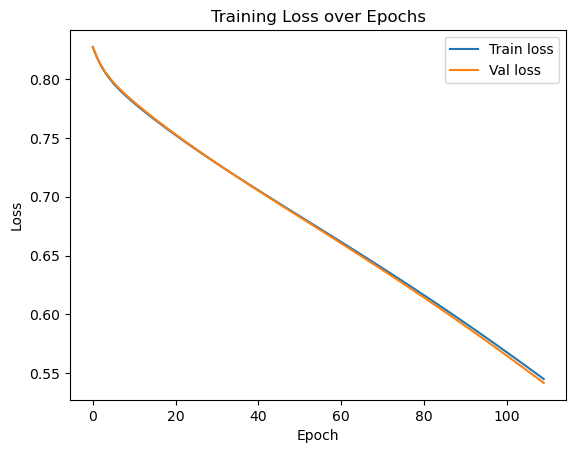

In [27]:
# theta_new1, losses = gradient_decent(lr, theta, x, y_actual, num_hidden_layer, input_size)
theta_2layer = gradient_decent(lr,num_epoch, theta, X_train, y_train,X_val,y_val, num_hidden_layer, input_size)


In [28]:
_, _, y_pred_test = forword_prop(X_test, theta_2layer, num_hidden_layer, input_size)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0).T
precision1, recall1, f1_score1, acc1 = evaluate_metrics(y_test, y_pred_test)
print("Evaluation matrix for 2 layer Neural Network ")
print(f"Test accuracy: {acc1*100}%")
print("Precision: ",precision1)
print("Recall: ",recall1)
print("F1_score: ",f1_score1)


Evaluation matrix for 2 layer Neural Network 
Test accuracy: 98.66666666666667%
Precision:  0.967741935483871
Recall:  1.0
F1_score:  0.9836065573770492


# 3 Hidden Layer Neural Network

Epoch 1, train_loss: 0.6905, train_acc: 51.71, Val_loss: 0.6904, val_acc: 52.00
Epoch 11, train_loss: 0.6831, train_acc: 51.71, Val_loss: 0.6829, val_acc: 52.00
Epoch 21, train_loss: 0.6757, train_acc: 51.71, Val_loss: 0.6756, val_acc: 52.00
Epoch 31, train_loss: 0.6674, train_acc: 51.71, Val_loss: 0.6674, val_acc: 52.00
Epoch 41, train_loss: 0.6579, train_acc: 52.57, Val_loss: 0.6579, val_acc: 54.67
Epoch 51, train_loss: 0.6465, train_acc: 57.71, Val_loss: 0.6467, val_acc: 66.67
Epoch 61, train_loss: 0.6328, train_acc: 71.71, Val_loss: 0.6330, val_acc: 73.33
Epoch 71, train_loss: 0.6162, train_acc: 80.57, Val_loss: 0.6166, val_acc: 85.33
Epoch 81, train_loss: 0.5963, train_acc: 86.86, Val_loss: 0.5968, val_acc: 94.67
Epoch 91, train_loss: 0.5728, train_acc: 92.86, Val_loss: 0.5732, val_acc: 98.67
Epoch 101, train_loss: 0.5452, train_acc: 95.71, Val_loss: 0.5457, val_acc: 98.67


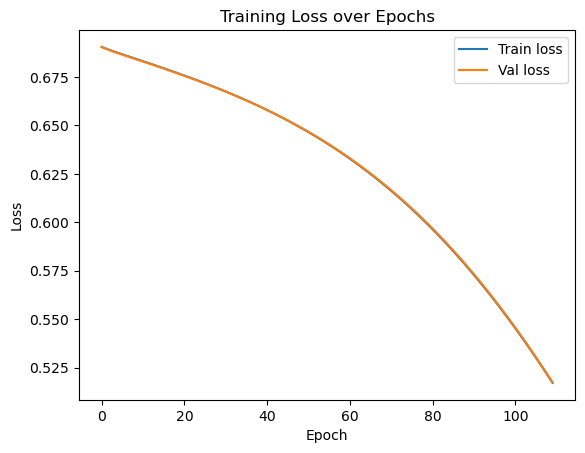

In [29]:
num_hidden_layer = 3
num_nodes_hidden_layers = [10,10,4]
input_size = 2
output_size = 1
lr = 0.001
num_epoch = 110
# Initilise Neural Network
theta3 = init_N_network( num_hidden_layer, num_nodes_hidden_layers, input_size, output_size )
theta_3layer = gradient_decent(lr,num_epoch, theta3, X_train, y_train,X_val,y_val, num_hidden_layer, input_size)


In [30]:
_, _, y_pred_test3 = forword_prop(X_test, theta_3layer, num_hidden_layer, input_size)
y_pred_test3 = np.where(y_pred_test3 > 0.5, 1, 0).T
precision3, recall3, f1_score3, acc3 = evaluate_metrics(y_test, y_pred_test3)
print("Evaluation matrix for 3 layer Neural Network ")
print(f"Test accuracy: {acc3*100}%")
print("Precision: ",precision3)
print("Recall: ",recall3)
print("F1_score: ",f1_score3)


Evaluation matrix for 3 layer Neural Network 
Test accuracy: 96.0%
Precision:  0.9090909090909091
Recall:  1.0
F1_score:  0.9523809523809523


# 4 Hidden Layer Neural Network

Epoch 1, train_loss: 0.7011, train_acc: 51.71, Val_loss: 0.7000, val_acc: 52.00
Epoch 11, train_loss: 0.6854, train_acc: 51.71, Val_loss: 0.6852, val_acc: 52.00
Epoch 21, train_loss: 0.6730, train_acc: 55.71, Val_loss: 0.6727, val_acc: 60.00
Epoch 31, train_loss: 0.5964, train_acc: 100.00, Val_loss: 0.5964, val_acc: 100.00


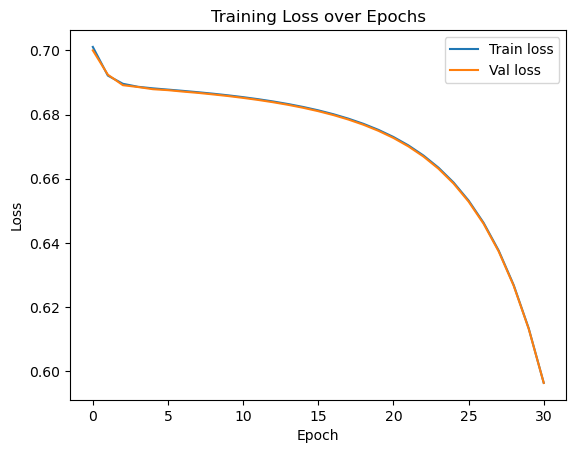

In [36]:
num_hidden_layer = 4
num_nodes_hidden_layers = [20,10,10,4]
input_size = 2
output_size = 1
lr = 0.01
num_epoch = 31
# Initilise Neural Network
theta4 = init_N_network( num_hidden_layer, num_nodes_hidden_layers, input_size, output_size )
theta_4layer = gradient_decent(lr,num_epoch, theta4, X_train, y_train,X_val,y_val, num_hidden_layer, input_size)


In [37]:
_, _, y_pred_test4 = forword_prop(X_test, theta_4layer, num_hidden_layer, input_size)
y_pred_test4 = np.where(y_pred_test4 > 0.5, 1, 0).T
precision4, recall4, f1_score4, acc4 = evaluate_metrics(y_test, y_pred_test4)
print("Evaluation matrix for 4 layer Neural Network ")
print(f"Test accuracy: {acc4*100}%")
print("Precision: ",precision4)
print("Recall: ",recall4)
print("F1_score: ",f1_score4)

Evaluation matrix for 4 layer Neural Network 
Test accuracy: 100.0%
Precision:  1.0
Recall:  1.0
F1_score:  1.0
